In [ ]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [ ]:
!pip install --upgrade --no-cache-dir gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 5.1.0
    Uninstalling gdown-5.1.0:
      Successfully uninstalled gdown-5.1.0


POC - training on a small dataset

In [ ]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


class DISDataset(torch.utils.data.Dataset):
    def __init__(self, images_path, masks_path, transform=None):
        self.images_path = images_path
        self.masks_path = masks_path
        self.images = sorted(os.listdir(images_path))
        self.masks = sorted(os.listdir(masks_path))
        self.transform = transform

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_path, self.images[idx])
        mask_path = os.path.join(self.masks_path, self.masks[idx])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform is not None:
            img = self.transform(img)

        mask = np.array(mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]  # remove the background

        masks = mask == obj_ids[:, None, None]

        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks

        return img, target

    def __len__(self):
        return len(self.images)


transform = T.Compose([
    T.ToTensor()
])


images_path = "drive/MyDrive/test/im"
masks_path = "drive/MyDrive/test/gt"

dataset = DISDataset(images_path, masks_path, transform=transform)
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=lambda x: tuple(zip(*x)))


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:

model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.001, weight_decay=0.0005)


num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_loss += losses.item()

    print(f"Epoch {epoch+1}, Loss: {train_loss/len(data_loader)}")

torch.save(model.state_dict(), "maskrcnn_dis5k.pth")


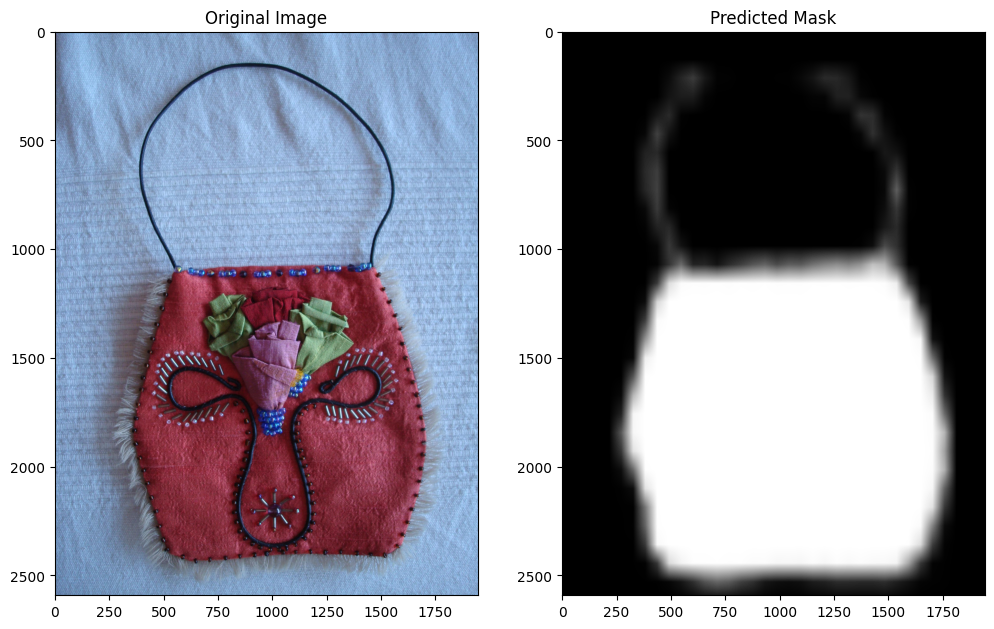

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms as T
from PIL import Image


def visualize_prediction(model, image_path, device):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    transform = T.ToTensor()
    img_tensor = transform(img).to(device)

    with torch.no_grad():
        pred = model([img_tensor])

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    if len(pred[0]["masks"]) > 0:
        mask = pred[0]["masks"][0, 0].cpu().detach().numpy()
        plt.imshow(mask, cmap='gray')
        plt.title("Predicted Mask")
    else:
        plt.title("No mask detected")
    plt.show()


model.load_state_dict(torch.load("maskrcnn_dis5k.pth"))
model.to(device)


test_image_path = "drive/MyDrive/test/im/1#Accessories#1#Bag#2339506821_83cf9f1d22_o.jpg"


visualize_prediction(model, test_image_path, device)


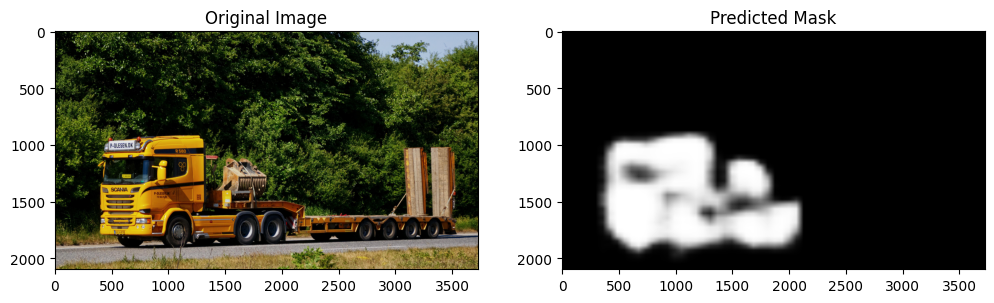

In [ ]:
model.load_state_dict(torch.load("maskrcnn_dis5k.pth"))
model.to(device)

test_image_path = "drive/MyDrive/test/im/6#Automobile#12#Truck#44311991260_8af156dbbd_o.jpg"

visualize_prediction(model, test_image_path, device)


---------------

fine-tuning whole network

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You 

Training a new model.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1, Train Loss: 0.8349826638515179
Epoch 1, Validation Loss: 0.6808914691209793
Epoch 2, Train Loss: 0.6183603506821852
Epoch 2, Validation Loss: 0.5228566490113735
Epoch 3, Train Loss: 0.5590045190774477
Epoch 3, Validation Loss: 0.5315764434635639
Epoch 4, Train Loss: 0.5071843720399416
Epoch 4, Validation Loss: 0.5787215642631054
Epoch 5, Train Loss: 0.4098540828778194
Epoch 5, Validation Loss: 0.4781585671007633
Epoch 6, Train Loss: 0.3516979178557029
Epoch 6, Validation Loss: 0.42059172689914703
Epoch 7, Train Loss: 0.3216891061801177
Epoch 7, Validation Loss: 0.4045424610376358
Epoch 8, Train Loss: 0.2992411808325694
Epoch 8, Validation Loss: 0.3910680338740349
Epoch 9, Train Loss: 0.27428922607348516
Epoch 9, Validation Loss: 0.38858605548739433
Epoch 10, Train Loss: 0.25169314925487224
Epoch 10, Validation Loss: 0.3792163264006376
Epoch 11, Train Loss: 0.2420616069665322
Epoch 11, Validation Loss: 0.4285896047949791
Epoch 12, Train Loss: 0.2333404690027237
Epoch 12, Valida

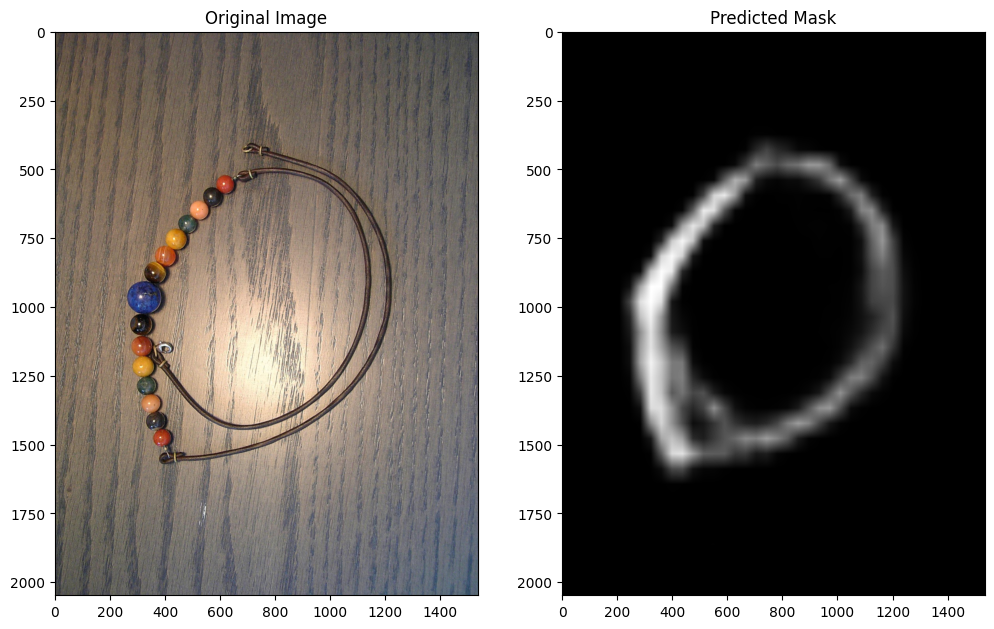

In [ ]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import random

import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from sklearn.model_selection import train_test_split


class DISDataset(torch.utils.data.Dataset):
    def __init__(self, images_path, masks_path, indices, transform=None):
        self.images_path = images_path
        self.masks_path = masks_path
        self.indices = indices
        self.images = sorted(os.listdir(images_path))
        self.masks = sorted(os.listdir(masks_path))
        self.transform = transform

    def __getitem__(self, idx):
        img_idx = self.indices[idx]
        img_path = os.path.join(self.images_path, self.images[img_idx])
        mask_path = os.path.join(self.masks_path, self.masks[img_idx])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform is not None:
            img = self.transform(img)

        mask = np.array(mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]  # remove the background

        masks = mask == obj_ids[:, None, None]

        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks

        return img, target

    def __len__(self):
        return len(self.indices)


transform = T.Compose([
    T.ToTensor()
])

images_path = "drive/MyDrive/test2/im"
masks_path = "drive/MyDrive/test2/gt"

all_indices = list(range(len(os.listdir(images_path))))
train_indices, val_indices = train_test_split(all_indices, test_size=0.1, random_state=42)

train_dataset = DISDataset(images_path, masks_path, train_indices, transform=transform)
val_dataset = DISDataset(images_path, masks_path, val_indices, transform=transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=2, shuffle=False, num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

model_path = "maskrcnn_dis5k.pth"
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print("Model loaded from disk.")
else:
    print("Training a new model.")

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_loss += losses.item()

    print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader)}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, targets in val_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            model.train()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()

    print(f"Epoch {epoch+1}, Validation Loss: {val_loss/len(val_loader)}")

torch.save(model.state_dict(), model_path)
print("Model saved to disk.")

def visualize_prediction(model, image_path, device):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    transform = T.ToTensor()
    img_tensor = transform(img).to(device)

    with torch.no_grad():
        pred = model([img_tensor])

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    if len(pred[0]["masks"]) > 0:
        mask = pred[0]["masks"][0, 0].cpu().detach().numpy()
        plt.imshow(mask, cmap='gray')
        plt.title("Predicted Mask")
    else:
        plt.title("No mask detected")
    plt.show()


model.load_state_dict(torch.load(model_path))
model.to(device)

random_idx = random.choice(val_indices)
random_image_path = os.path.join(images_path, os.listdir(images_path)[random_idx])

visualize_prediction(model, random_image_path, device)


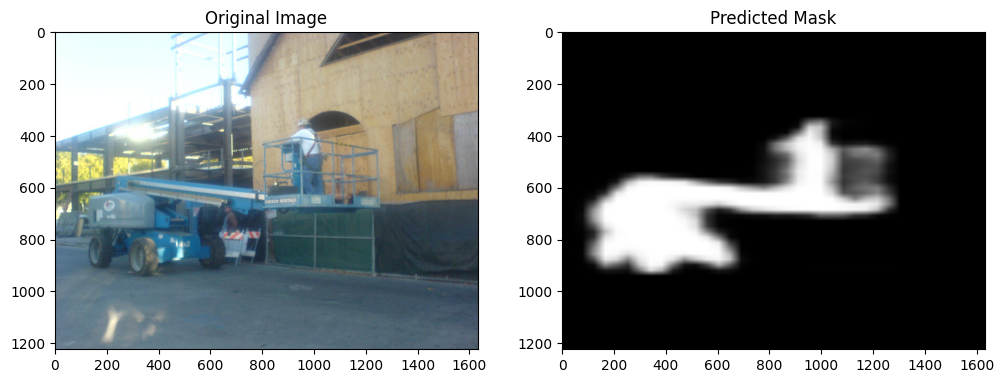

In [ ]:
random_idx = random.choice(val_indices)
random_image_path = os.path.join(images_path, os.listdir(images_path)[random_idx])

visualize_prediction(model, random_image_path, device)

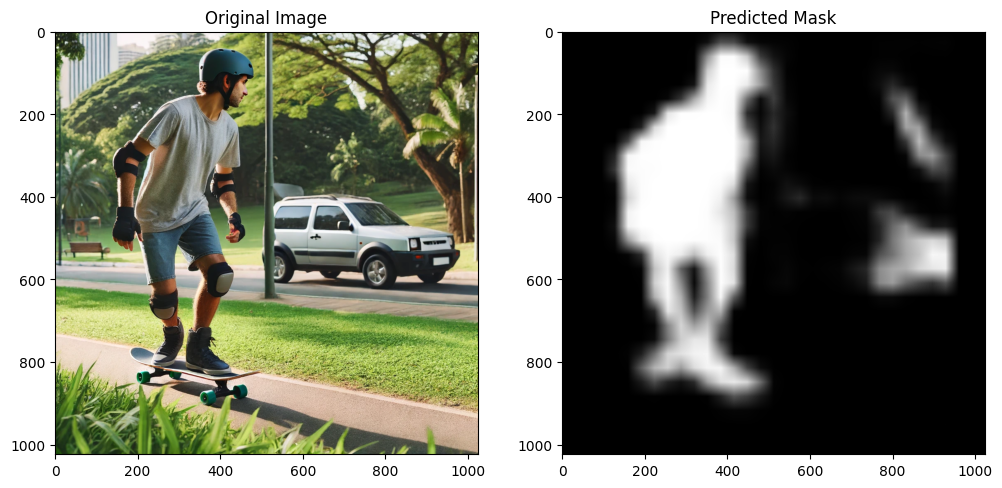

In [ ]:
gen_image_path = "drive/MyDrive/random_image.png"
visualize_prediction(model, gen_image_path, device)

PYTORCH LIGHTNING

In [ ]:
! pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.2/812.2 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 15.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-many

In [ ]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from sklearn.model_selection import train_test_split

import pytorch_lightning as pl
from torch.utils.data import DataLoader

class DISDataset(torch.utils.data.Dataset):
    def __init__(self, images_path, masks_path, indices, transform=None):
        self.images_path = images_path
        self.masks_path = masks_path
        self.indices = indices
        self.images = sorted(os.listdir(images_path))
        self.masks = sorted(os.listdir(masks_path))
        self.transform = transform

    def __getitem__(self, idx):
        img_idx = self.indices[idx]
        img_path = os.path.join(self.images_path, self.images[img_idx])
        mask_path = os.path.join(self.masks_path, self.masks[img_idx])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform is not None:
            img = self.transform(img)

        mask = np.array(mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]  # remove the background

        masks = mask == obj_ids[:, None, None]

        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks

        return img, target

    def __len__(self):
        return len(self.indices)


transform = T.Compose([
    T.ToTensor()
])

images_path = "drive/MyDrive/test2/im"
masks_path = "drive/MyDrive/test2/gt"

all_indices = list(range(len(os.listdir(images_path))))
train_indices, val_indices = train_test_split(all_indices, test_size=0.1, random_state=42)

train_dataset = DISDataset(images_path, masks_path, train_indices, transform=transform)
val_dataset = DISDataset(images_path, masks_path, val_indices, transform=transform)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_dataset, batch_size=1, shuffle=True, num_workers=4,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn
)

class MaskRCNNModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

        in_features_mask = self.model.roi_heads.mask_predictor.conv5_mask.in_channels
        hidden_layer = 256
        self.model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, 2)

    def forward(self, images, targets=None):
        if targets is None:
            return self.model(images)
        return self.model(images, targets)

    def training_step(self, batch, batch_idx):
        images, targets = batch
        images = list(image.to(self.device) for image in images)
        targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
        loss_dict = self.model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        self.log('train_loss', losses, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return losses

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        images = list(image.to(self.device) for image in images)
        targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]

        loss_dict_list = self.model(images, targets)
        val_loss = 0
        for loss_dict in loss_dict_list:
            if 'boxes' in loss_dict:
                val_loss += torch.sum(loss_dict['boxes'])
            if 'masks' in loss_dict:
                val_loss += torch.sum(loss_dict['masks'])
            val_loss += batch_loss.item()
        self.log('val_loss', losses, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return val_loss

    def configure_optimizers(self):
        params = [p for p in self.model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
        return optimizer

model = MaskRCNNModel()

trainer = pl.Trainer(
    max_epochs=100,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    accumulate_grad_batches=4
)

trainer.fit(model, train_loader, val_loader)

torch.save(model.state_dict(), "maskrcnn_dis5k.pth")

def visualize_prediction(model, image_path, device):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    transform = T.ToTensor()
    img_tensor = transform(img).to(device)

    with torch.no_grad():
        pred = model([img_tensor])

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    if len(pred[0]["masks"]) > 0:
        mask = pred[0]["masks"][0, 0].cpu().detach().numpy()
        plt.imshow(mask, cmap='gray')
        plt.title("Predicted Mask")
    else:
        plt.title("No mask detected")
    plt.show()

model.load_state_dict(torch.load("maskrcnn_dis5k.pth"))
model.to(device)

test_image_path = "drive/MyDrive/test2/im/1#Accessories#1#Bag#2339506821_83cf9f1d22_o.jpg"

visualize_prediction(model, test_image_path, device)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | model | MaskRCNN | 43.9 M | train
-------------------------------------------
43.7 M    Trainable params
222 K     Non-trainable params
43.9 M    Total params
175.690   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.47 GiB. GPU 

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()
del model

del train_loader
del val_loader

torch.cuda.empty_cache()

Fine-tuning only last layers (+last from the backbone)

Training a new model.
Epoch 1, Train Loss: 1.3338443100452424
Epoch 1, Validation Loss: 0.5487370900809765
Epoch 2, Train Loss: 0.6226992524587192
Epoch 2, Validation Loss: 0.5480170398950577
Epoch 3, Train Loss: 0.6307525240457975
Epoch 3, Validation Loss: 0.5431631654500961
Epoch 4, Train Loss: 0.5887498896855574
Epoch 4, Validation Loss: 0.5630603954195976
Epoch 5, Train Loss: 0.5445700379518362
Epoch 5, Validation Loss: 0.5106328502297401
Epoch 6, Train Loss: 0.49258988591340874
Epoch 6, Validation Loss: 0.5350227914750576
Epoch 7, Train Loss: 0.4811752071747413
Epoch 7, Validation Loss: 0.5303943753242493
Epoch 8, Train Loss: 0.4772487534926488
Epoch 8, Validation Loss: 0.5220798850059509
Epoch 9, Train Loss: 0.4714788464399485
Epoch 9, Validation Loss: 0.5189374908804893
Epoch 10, Train Loss: 0.468855737722837
Epoch 10, Validation Loss: 0.5141074135899544
Epoch 11, Train Loss: 0.46637110068247867
Epoch 11, Validation Loss: 0.5175574868917465
Epoch 12, Train Loss: 0.47100641177250

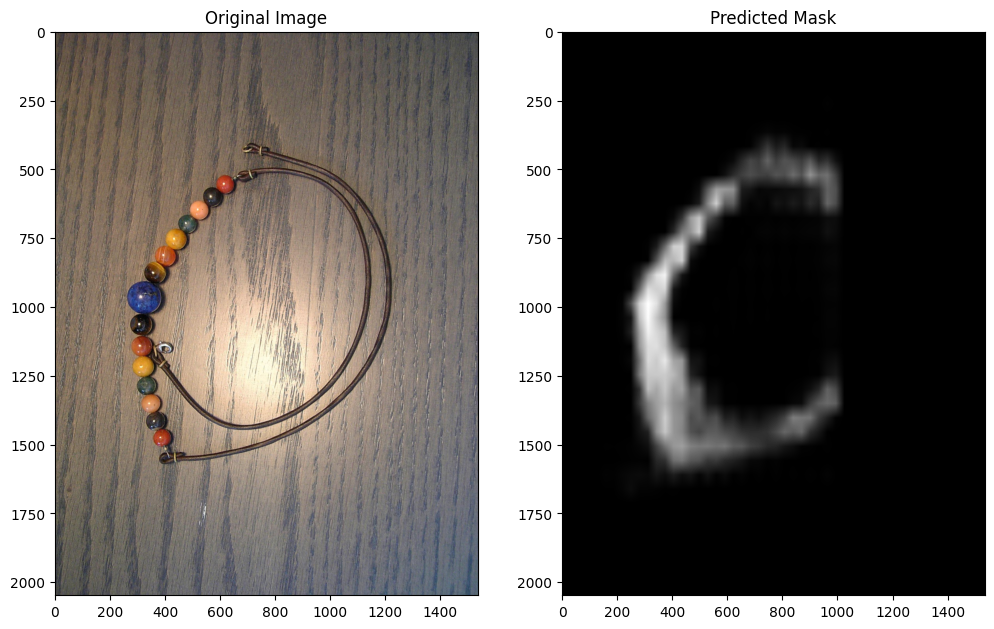

In [ ]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import random

import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from sklearn.model_selection import train_test_split


class DISDataset(torch.utils.data.Dataset):
    def __init__(self, images_path, masks_path, indices, transform=None):
        self.images_path = images_path
        self.masks_path = masks_path
        self.indices = indices
        self.images = sorted(os.listdir(images_path))
        self.masks = sorted(os.listdir(masks_path))
        self.transform = transform

    def __getitem__(self, idx):
        img_idx = self.indices[idx]
        img_path = os.path.join(self.images_path, self.images[img_idx])
        mask_path = os.path.join(self.masks_path, self.masks[img_idx])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform is not None:
            img = self.transform(img)

        mask = np.array(mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]  # remove the background

        masks = mask == obj_ids[:, None, None]

        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks

        return img, target

    def __len__(self):
        return len(self.indices)


transform = T.Compose([
    T.ToTensor()
])

images_path = "drive/MyDrive/test2/im"
masks_path = "drive/MyDrive/test2/gt"

all_indices = list(range(len(os.listdir(images_path))))
train_indices, val_indices = train_test_split(all_indices, test_size=0.1, random_state=42)

train_dataset = DISDataset(images_path, masks_path, train_indices, transform=transform)
val_dataset = DISDataset(images_path, masks_path, val_indices, transform=transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=2, shuffle=False, num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, 2)

for param in model.parameters():
    param.requires_grad = False

for param in model.backbone.body.layer4.parameters():
    param.requires_grad = True

for param in model.roi_heads.box_predictor.parameters():
    param.requires_grad = True

for param in model.roi_heads.mask_predictor.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model_path = "maskrcnn_dis5k.pth"
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print("Model loaded from disk.")
else:
    print("Training a new model.")

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_loss += losses.item()

    print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader)}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, targets in val_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            model.train()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()

    # Step the learning rate scheduler
    lr_scheduler.step()

    print(f"Epoch {epoch+1}, Validation Loss: {val_loss/len(val_loader)}")

# Save model after training
torch.save(model.state_dict(), model_path)
print("Model saved to disk.")

def visualize_prediction(model, image_path, device):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    transform = T.ToTensor()
    img_tensor = transform(img).to(device)

    with torch.no_grad():
        pred = model([img_tensor])

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    if len(pred[0]["masks"]) > 0:
        mask = pred[0]["masks"][0, 0].cpu().detach().numpy()
        plt.imshow(mask, cmap='gray')
        plt.title("Predicted Mask")
    else:
        plt.title("No mask detected")
    plt.show()

model.load_state_dict(torch.load(model_path))
model.to(device)

random_idx = random.choice(val_indices)
random_image_path = os.path.join(images_path, os.listdir(images_path)[random_idx])

visualize_prediction(model, random_image_path, device)

In [ ]:
import torch
import torchvision

model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, 2)

print("Full model architecture:")
print(model)

print("\nBackbone:")
print(model.backbone)

print("\nRPN (Region Proposal Network):")
print(model.rpn)

print("\nROI Heads:")
print(model.roi_heads)

print("\nBox Predictor:")
print(model.roi_heads.box_predictor)

print("\nMask Predictor:")
print(model.roi_heads.mask_predictor)

print("\nLayers and their 'requires_grad' status:")
for name, param in model.named_parameters():
    print(f"Layer: {name} | Requires Grad: {param.requires_grad}")


Full model architecture:
MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)


TRAIN MORE

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1, Train Loss: 0.751701453098884
Epoch 1, Validation Loss: 0.4837053567171097
Best model saved.
Epoch 2, Train Loss: 0.45005511733201836
Epoch 2, Validation Loss: 0.4425605274736881
Best model saved.
Epoch 3, Train Loss: 0.42039761818372284
Epoch 3, Validation Loss: 0.5002951696515083
Epoch 4, Train Loss: 0.39536701440811156
Epoch 4, Validation Loss: 0.4394133910536766
Best model saved.
Epoch 5, Train Loss: 0.3509385631634639
Epoch 5, Validation Loss: 0.3889698423445225
Best model saved.
Epoch 6, Train Loss: 0.3333044728407493
Epoch 6, Validation Loss: 0.39184705913066864
Epoch 7, Train Loss: 0.31426979922331294
Epoch 7, Validation Loss: 0.38185480795800686
Best model saved.
Epoch 8, Train Loss: 0.2935579006488507
Epoch 8, Validation Loss: 0.38465255685150623
Epoch 9, Train Loss: 0.28169366946587193
Epoch 9, Validation Loss: 0.37566328048706055
Best model saved.
Epoch 10, Train Loss: 0.2744358053574195
Epoch 10, Validation Loss: 0.38669094629585743


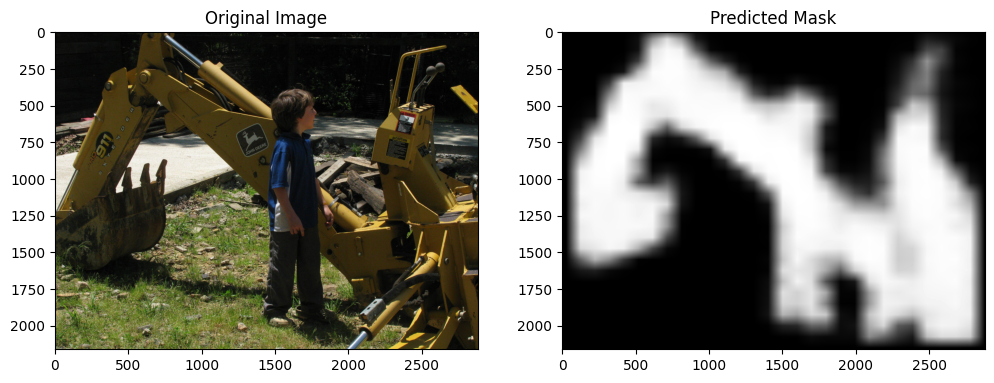

In [ ]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import random

import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from sklearn.model_selection import train_test_split

class DISDataset(torch.utils.data.Dataset):
    def __init__(self, images_path, masks_path, indices, transform=None):
        self.images_path = images_path
        self.masks_path = masks_path
        self.indices = indices
        self.images = sorted(os.listdir(images_path))
        self.masks = sorted(os.listdir(masks_path))
        self.transform = transform

    def __getitem__(self, idx):
        img_idx = self.indices[idx]
        img_path = os.path.join(self.images_path, self.images[img_idx])
        mask_path = os.path.join(self.masks_path, self.masks[img_idx])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform is not None:
            img = self.transform(img)

        mask = np.array(mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]  # remove the background

        masks = mask == obj_ids[:, None, None]

        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks

        return img, target

    def __len__(self):
        return len(self.indices)


transform = T.Compose([
    T.ToTensor()
])

images_path = "drive/MyDrive/test2/im"
masks_path = "drive/MyDrive/test2/gt"

all_indices = list(range(len(os.listdir(images_path))))
train_indices, val_indices = train_test_split(all_indices, test_size=0.1, random_state=42)

train_dataset = DISDataset(images_path, masks_path, train_indices, transform=transform)
val_dataset = DISDataset(images_path, masks_path, val_indices, transform=transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=2, shuffle=False, num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

num_epochs = 10
best_val_loss = float("inf")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_loss += losses.item()

    print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader)}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, targets in val_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            model.train()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()

    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}, Validation Loss: {val_loss}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "maskrcnn_dis5k_best.pth")
        print("Best model saved.")

model.load_state_dict(torch.load("maskrcnn_dis5k_best.pth"))
model.to(device)

def visualize_prediction(model, image_path, device):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    transform = T.ToTensor()
    img_tensor = transform(img).to(device)

    with torch.no_grad():
        pred = model([img_tensor])

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    if len(pred[0]["masks"]) > 0:
        mask = pred[0]["masks"][0, 0].cpu().detach().numpy()
        plt.imshow(mask, cmap='gray')
        plt.title("Predicted Mask")
    else:
        plt.title("No mask detected")
    plt.show()

random_idx = random.choice(val_indices)
random_image_path = os.path.join(images_path, os.listdir(images_path)[random_idx])

visualize_prediction(model, random_image_path, device)


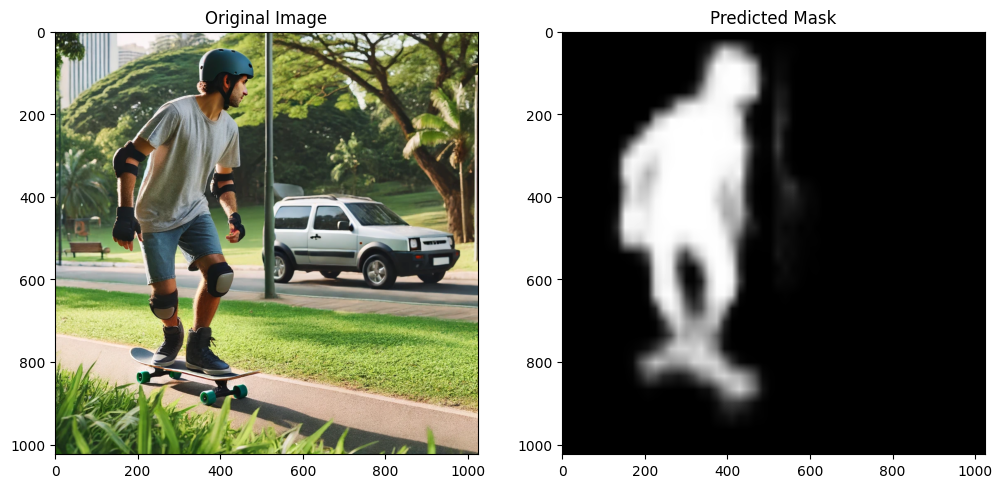

In [ ]:
gen_image_path = "drive/MyDrive/random_image.png"
visualize_prediction(model, gen_image_path, device)

Data transformation - rotating and a bigger batch - 4

Best model loaded.
Epoch 1, Train Loss: 0.3174201877731265
Epoch 1, Validation Loss: 0.39260218292474747
Best model saved.
Epoch 2, Train Loss: 0.30304736305366864
Epoch 2, Validation Loss: 0.3886285498738289
Best model saved.
Epoch 3, Train Loss: 0.291268606077541
Epoch 3, Validation Loss: 0.3752203658223152
Best model saved.
Epoch 4, Train Loss: 0.2904170963800315
Epoch 4, Validation Loss: 0.3748272731900215
Best model saved.
Epoch 5, Train Loss: 0.2790590086669633
Epoch 5, Validation Loss: 0.35607267171144485
Best model saved.
Epoch 6, Train Loss: 0.2812598076733676
Epoch 6, Validation Loss: 0.4036904126405716
Epoch 7, Train Loss: 0.27227969467639923
Epoch 7, Validation Loss: 0.3570822849869728
Epoch 8, Train Loss: 0.2685859501361847
Epoch 8, Validation Loss: 0.43191876262426376
Epoch 9, Train Loss: 0.2640965666734811
Epoch 9, Validation Loss: 0.39250949770212173
Epoch 10, Train Loss: 0.26289473474025726
Epoch 10, Validation Loss: 0.3733276203274727


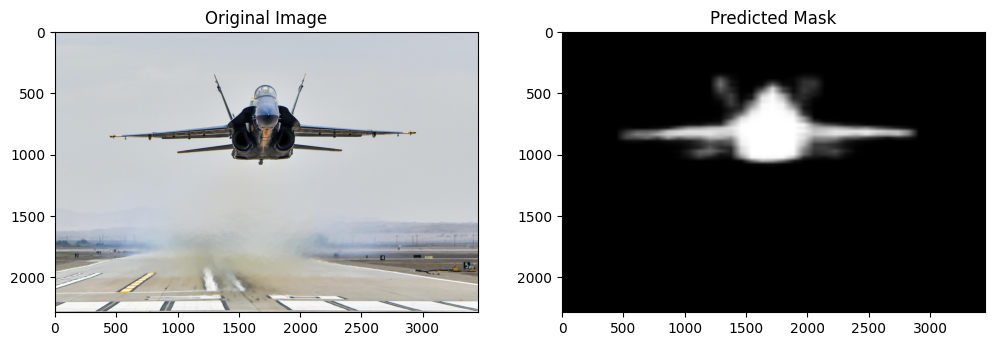

In [ ]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import random

import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from sklearn.model_selection import train_test_split

class DISDataset(torch.utils.data.Dataset):
    def __init__(self, images_path, masks_path, indices, transform=None):
        self.images_path = images_path
        self.masks_path = masks_path
        self.indices = indices
        self.images = sorted(os.listdir(images_path))
        self.masks = sorted(os.listdir(masks_path))
        self.transform = transform

    def __getitem__(self, idx):
        img_idx = self.indices[idx]
        img_path = os.path.join(self.images_path, self.images[img_idx])
        mask_path = os.path.join(self.masks_path, self.masks[img_idx])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform is not None:
            angle = random.uniform(-30, 30)
            img = img.rotate(angle)
            mask = mask.rotate(angle)

            img = self.transform(img)
            mask = np.array(mask)

        else:
            img = T.ToTensor()(img)
            mask = np.array(mask)

        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]  # remove the background

        masks = mask == obj_ids[:, None, None]

        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks

        return img, target

    def __len__(self):
        return len(self.indices)

transform = T.Compose([
    T.ToTensor()
])

images_path = "drive/MyDrive/test2/im"
masks_path = "drive/MyDrive/test2/gt"

all_indices = list(range(len(os.listdir(images_path))))
train_indices, val_indices = train_test_split(all_indices, test_size=0.1, random_state=42)

train_dataset = DISDataset(images_path, masks_path, train_indices, transform=transform)
val_dataset = DISDataset(images_path, masks_path, val_indices, transform=transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=4, shuffle=True, num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=4, shuffle=False, num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model_path = "maskrcnn_dis5k_best.pth"
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print("Best model loaded.")

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

num_epochs = 10
best_val_loss = float("inf")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_loss += losses.item()

    print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader)}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, targets in val_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            model.train()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()

    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}, Validation Loss: {val_loss}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), model_path)
        print("Best model saved.")

model.load_state_dict(torch.load(model_path))
model.to(device)

def visualize_prediction(model, image_path, device):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    transform = T.ToTensor()
    img_tensor = transform(img).to(device)

    with torch.no_grad():
        pred = model([img_tensor])

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    if len(pred[0]["masks"]) > 0:
        mask = pred[0]["masks"][0, 0].cpu().detach().numpy()
        plt.imshow(mask, cmap='gray')
        plt.title("Predicted Mask")
    else:
        plt.title("No mask detected")
    plt.show()

random_idx = random.choice(val_indices)
random_image_path = os.path.join(images_path, os.listdir(images_path)[random_idx])

visualize_prediction(model, random_image_path, device)


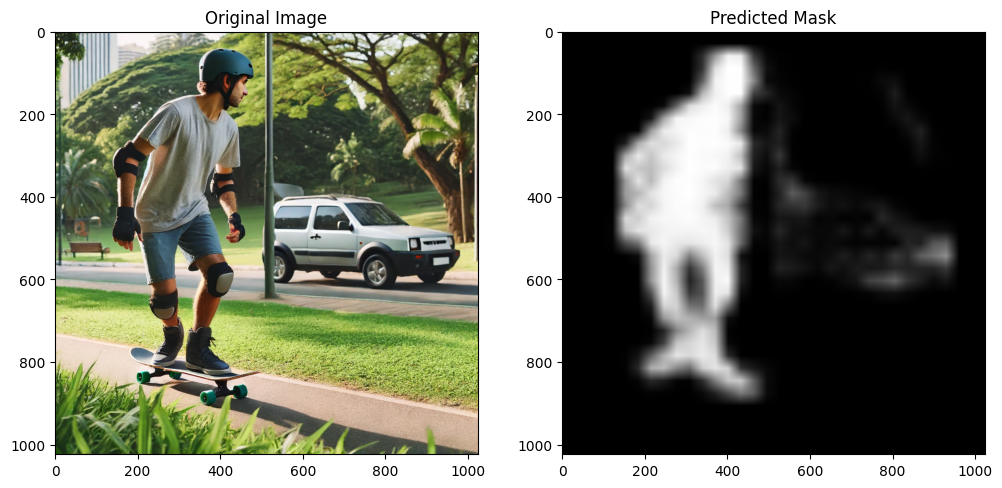

In [ ]:
gen_image_path = "drive/MyDrive/random_image.png"
visualize_prediction(model, gen_image_path, device)

Best model loaded.
Epoch 1, Train Loss: 0.28925013060753163
Epoch 1, Validation Loss: 3761262.59375
Best model saved.
Epoch 2, Train Loss: 0.2744247991305131
Epoch 2, Validation Loss: 3781285.90625
Epoch 3, Train Loss: 0.270960094837042
Epoch 3, Validation Loss: 3105442.609375
Best model saved.
Epoch 4, Train Loss: 0.2709100230382039
Epoch 4, Validation Loss: 4352023.46875
Epoch 5, Train Loss: 0.26261393909270947
Epoch 5, Validation Loss: 4073704.96875
Epoch 6, Train Loss: 0.2612932095160851
Epoch 6, Validation Loss: 3415627.0625
Epoch 7, Train Loss: 0.25337521227506493
Epoch 7, Validation Loss: 3626069.5
Epoch 8, Train Loss: 0.24727110793957344
Epoch 8, Validation Loss: 3617539.125
Epoch 9, Train Loss: 0.24886528024306664
Epoch 9, Validation Loss: 3800928.359375
Epoch 10, Train Loss: 0.24794595218621768
Epoch 10, Validation Loss: 4151784.125


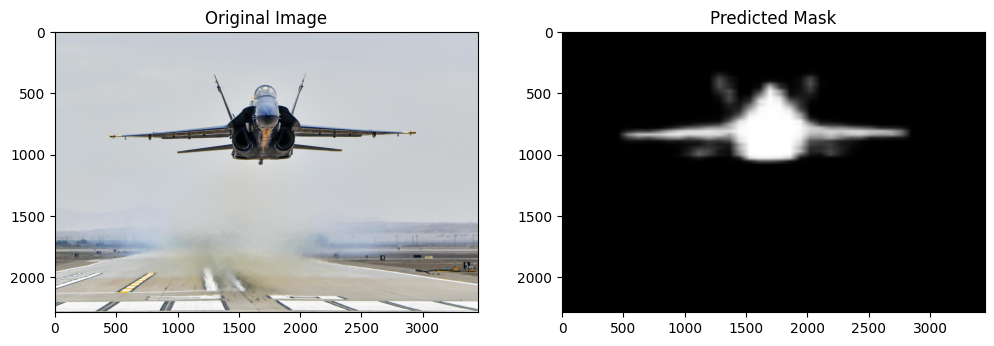

In [ ]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import random

import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from sklearn.model_selection import train_test_split

class DISDataset(torch.utils.data.Dataset):
    def __init__(self, images_path, masks_path, indices, transform=None):
        self.images_path = images_path
        self.masks_path = masks_path
        self.indices = indices
        self.images = sorted(os.listdir(images_path))
        self.masks = sorted(os.listdir(masks_path))
        self.transform = transform

    def __getitem__(self, idx):
        img_idx = self.indices[idx]
        img_path = os.path.join(self.images_path, self.images[img_idx])
        mask_path = os.path.join(self.masks_path, self.masks[img_idx])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform is not None:
            angle = random.uniform(-30, 30)
            img = img.rotate(angle)
            mask = mask.rotate(angle)

            img = self.transform(img)
            mask = np.array(mask)

        else:
            img = T.ToTensor()(img)
            mask = np.array(mask)

        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]  # remove the background

        masks = mask == obj_ids[:, None, None]

        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks

        return img, target

    def __len__(self):
        return len(self.indices)

transform = T.Compose([
    T.ToTensor()
])

images_path = "drive/MyDrive/test2/im"
masks_path = "drive/MyDrive/test2/gt"

all_indices = list(range(len(os.listdir(images_path))))
train_indices, val_indices = train_test_split(all_indices, test_size=0.1, random_state=42)

train_dataset = DISDataset(images_path, masks_path, train_indices, transform=transform)
val_dataset = DISDataset(images_path, masks_path, val_indices, transform=transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=2, shuffle=False, num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model_path = "maskrcnn_dis5k_best.pth"
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print("Best model loaded.")

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

num_epochs = 10
best_val_loss = float("inf")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_loss += losses.item()

    print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader)}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, targets in val_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict_list = model(images, targets)
            batch_loss = 0
            for loss_dict in loss_dict_list:
                if 'boxes' in loss_dict:
                    batch_loss += torch.sum(loss_dict['boxes'])
                if 'masks' in loss_dict:
                    batch_loss += torch.sum(loss_dict['masks'])
                if 'scores' in loss_dict:
                    batch_loss += torch.sum(loss_dict['scores'])
            val_loss += batch_loss.item()

    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}, Validation Loss: {val_loss}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), model_path)
        print("Best model saved.")

model.load_state_dict(torch.load(model_path))
model.to(device)

def visualize_prediction(model, image_path, device):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    transform = T.ToTensor()
    img_tensor = transform(img).to(device)

    with torch.no_grad():
        pred = model([img_tensor])

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    if len(pred[0]["masks"]) > 0:
        mask = pred[0]["masks"][0, 0].cpu().detach().numpy()
        plt.imshow(mask, cmap='gray')
        plt.title("Predicted Mask")
    else:
        plt.title("No mask detected")
    plt.show()

random_idx = random.choice(val_indices)
random_image_path = os.path.join(images_path, os.listdir(images_path)[random_idx])

visualize_prediction(model, random_image_path, device)
